In [84]:
from transformers import AutoTokenizer, AutoConfig, AutoModelForSequenceClassification
from scipy.special import softmax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
df = pd.read_csv('tweet.csv')

In [86]:
df.head()

,No,Date,Username,Tweet
0,1,2022-05-30 23:59:42+00:00,fednanen,@arkulari Makes me sick that some CFC fans hav...
1,2,2022-05-30 23:59:39+00:00,thvstwt,@Louis_Tomlinson did you watch the UCL final?
2,3,2022-05-30 23:59:22+00:00,lunatik1887,@MadeiraCakes @MoBob8208 @ethanpvt @Ultra_Suri...
3,4,2022-05-30 23:59:18+00:00,HxnchoIini,@mackutdd Says all of this but has only seen h...
4,5,2022-05-30 23:59:16+00:00,mxfahad3,"Vini, Havertz, Coman, Origi, Salah, Bale, Benz..."


**Preprocessing**

In [87]:
df.Tweet = df.Tweet.replace(r'\n',' ', regex=True)

In [88]:
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

In [89]:
df['Tweet'] = df['Tweet'].map(lambda x: preprocess(x))

In [90]:
df.Tweet.head()

0    @user Makes me sick that some CFC fans have fo...
1                   @user did you watch the UCL final?
2    @user @user @user @user Stop talking about the...
3    @user Says all of this but has only seen his U...
4    Vini, Havertz, Coman, Origi, Salah, Bale, Benz...
Name: Tweet, dtype: object

**Load Model and Tokenizing**

In [91]:
roberta = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
model = AutoModelForSequenceClassification.from_pretrained(roberta)
tokenizer = AutoTokenizer.from_pretrained(roberta)
config = AutoConfig.from_pretrained(roberta)
model.save_pretrained(roberta)
tokenizer.save_pretrained(roberta)
labels = ['Negative', 'Neutral', 'Positive']

**Sentiment**

In [92]:
def sentiment(text):
    encoded_input = tokenizer(preprocess(text), return_tensors='pt')
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    max_value = max(scores)
    list_scores = list(scores)
    index = list_scores.index(max_value)
    return pd.Series([max_value, labels[index]])

In [93]:
df[['Score', 'Label']] = df['Tweet'].apply(lambda x: sentiment(x))

In [94]:
df.head()

,No,Date,Username,Tweet,Score,Label
0,1,2022-05-30 23:59:42+00:00,fednanen,@user Makes me sick that some CFC fans have fo...,0.888830,Negative
1,2,2022-05-30 23:59:39+00:00,thvstwt,@user did you watch the UCL final?,0.947892,Neutral
2,3,2022-05-30 23:59:22+00:00,lunatik1887,@user @user @user @user Stop talking about the...,0.690600,Neutral
3,4,2022-05-30 23:59:18+00:00,HxnchoIini,@user Says all of this but has only seen his U...,0.558788,Neutral
4,5,2022-05-30 23:59:16+00:00,mxfahad3,"Vini, Havertz, Coman, Origi, Salah, Bale, Benz...",0.836510,Neutral


In [95]:
df.Tweet[789]

'@user Your piece about the UCL final neglected to mention the train strike in Paris. Supporters were being funneled from a single stop to the ground making the bottleneck grow worse as ever more people arrived.'

In [96]:
df.to_csv('tweet_after_2.csv')

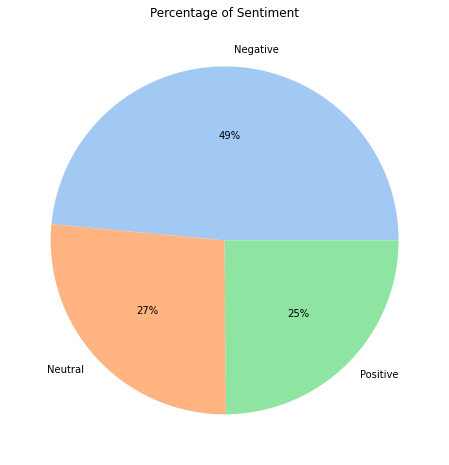

In [97]:
data = df['Label'].value_counts()
labels = df['Label'].unique()
colors = sns.color_palette('pastel')[0:5]
plt.figure(figsize=(8,8))
plt.title('Percentage of Sentiment')
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [98]:
df['Label'].value_counts()

Neutral     4851
Positive    2661
Negative    2488
Name: Label, dtype: int64